# Imported modules

In [ ]:
# %%file intel_images_cls_modules.py

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms
from torch.autograd import Variable

import albumentations as A

import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

import time
import datetime
import os
import copy
import PIL
import cv2
from google.colab.patches import cv2_imshow

from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, accuracy_score

import shutil
import glob
from zipfile import ZipFile
import seaborn as sns
import pandas as pd
import numpy as np
import random

# This Data contains around 25k images of size 150x150 distributed under 6 categories.
# {'buildings' -> 0,
# 'forest' -> 1,
# 'glacier' -> 2,
# 'mountain' -> 3,
# 'sea' -> 4,
# 'street' -> 5 }


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(f'Working on device= {device}')


torch.set_printoptions(linewidth=120)
print()
# print(torch.cuda.get_device_name(torch.cuda.current_device()))
# print('torch: ',torch.__version__)

Working on device= cuda



In [ ]:
!pip install torchmetrics
!pip install torchinfo
!pip install torchviz
!pip install neptune-client torch torchvision

import torchmetrics
# from torchmetrics.functional import f1, fbeta, precision, recall, cohen_kappa, matthews_corrcoef, accuracy, roc
from torchinfo import summary
from torchviz import make_dot

     |████████████████████████████████| 329 kB 4.0 MB/s 


In [182]:
import neptune.new as neptune
from neptune.new.types import File

run = neptune.init(project='armin.derencz/Intel-Image-Classification',
                   api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI4NGIyYzQ2My1iZjBhLTQ1MGQtYTJlMS04YmMxODBhNWVjYTUifQ==',
                   source_files=['*.py',
                                 '/content/drive/MyDrive/ColabNotebooks/Projects/intel_image/Intel_Image_Classification_PyTorch.ipynb'])

https://app.neptune.ai/armin.derencz/Intel-Image-Classification/e/IN-84
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


# Kaggle data downloading

In [ ]:
from google.colab import files
print("Please upload kaggle.json file.. \n")

upload = files.upload()

Please upload kaggle.json file.. 



Saving kaggle.json to kaggle.json


In [ ]:
%%time
!pip install -U -q kaggle
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d puneet6060/intel-image-classification

 97% 337M/346M [00:10<00:00, 16.6MB/s]
100% 346M/346M [00:10<00:00, 34.0MB/s]
CPU times: user 134 ms, sys: 94 ms, total: 228 ms
Wall time: 15.8 s


# Classes preparing

## DataWrangling

In [ ]:
# %%file data_wrangling.py

class DataWrangling:

  def __init__(self, path_to_zip_file):
    self.path_to_zip_file = path_to_zip_file


  def extract_archive(self):
    with ZipFile('intel-image-classification.zip', 'r') as zipobj:
      zipobj.extractall(path='data/')
      zipobj.close()

  def move_data_to_specific_dir(self, data_dir_path):
    for entry in os.scandir( data_dir_path ):
      if entry.is_dir():
        self.move_data_to_specific_dir(entry.path)
        path_to_data = glob.glob( entry.path + '/seg_*' )
        if path_to_data:
          if 'train' in path_to_data[0]:
            shutil.move( path_to_data[0], '/content/data/train/')

          elif 'test' in path_to_data[0]:
            shutil.move( path_to_data[0], '/content/data/val/')

          else:
            shutil.move( path_to_data[0], '/content/data/test/test/') # torchvision.datasets.ImageFolder expects subfolders
                                                                      # representing the classes containing images of the corresponding class.
  def del_directories(self, data_dir_path):
    dir_list_to_del = glob.glob( data_dir_path + '/seg_*' )
    [ shutil.rmtree(dir) for dir in dir_list_to_del ]

  def data_count(self, path):
    for self.entry in os.scandir( path= path ):
      if self.entry.is_dir():
        self.files_gen = ( self.image for self.image in os.listdir( self.entry.path ) )
        self.files_count = len( [ self.image for self.image in self.files_gen] )
        print( self.entry.name, self.files_count )

        if self.files_count >= 1:
          DataWrangling.data_count( self, path=self.entry.path )

  def connect_transformer_to_dataset(self, data_dir, transform_dict ):
    self.image_datasets = { x: datasets.ImageFolder(os.path.join(data_dir, x), transform_dict[x]) for x in ['train', 'val', 'test']}
    
    self.dataset_sizes = {x: len( self.image_datasets[x]) for x in ['train', 'val', 'test']}
    self.class_names = self.image_datasets['train'].classes

    print(f'dataset sizes: { self.dataset_sizes}')
    print(f'class names: { self.class_names}')  

  def create_dataloaders(self, batch_size):
    self.dataloaders = { x: torch.utils.data.DataLoader(self.image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']} 
    

## ImagePreprocessing

In [ ]:
# %%file image_preprocessing.py

class ImagePreprocessing:

  def __init__(self, dir_path):
    self.dir_path = dir_path
    self.counter = 0

  def _get_dir_name_from_path(self, path):
    self.last_slash_idx        = path.rfind('/')
    self.dir_name              = path[ self.last_slash_idx + 1: ]
    return self.dir_name    

  def _create_files_generator(self, class_name):
  
    self.path = os.path.join( self.dir_path, class_name ) 
    self.files_gen = ( self.image for self.image in os.listdir( self.path ) )
    return self.files_gen  

  def _open_image_file(self, img):
    self.image_path = os.path.join( self.path, img )
    self.image = cv2.imread( self.image_path, cv2.IMREAD_UNCHANGED )
    self.image = cv2.cvtColor( self.image, cv2.COLOR_BGR2RGB)
    
  def __image_size_of_one_class(self, class_name):
    self.files_gen = self._create_files_generator( class_name )
    self.image = next( self.files_gen )
    self._open_image_file( self.image )
    self.height, self.weight, _ = self.image.shape
    self.im_resolution = self.height, self.weight
    print(f'{self.i}: {self.class_name}: {self.im_resolution}')
  
  def image_size_of_each_class(self):
    self.dir_name= self._get_dir_name_from_path( path=self.dir_path )
    self.class_names_list = os.listdir(self.dir_path)    # ????
    print(f'Sizes of images in each class in { self.dir_name} data:')
    for self.i, self.class_name in enumerate( self.class_names_list):
      self.__image_size_of_one_class( self.class_name )
   
  def _get_image_channels_as_array(self):
      self._open_image_file( self.image )
      self.r_array, self.g_array, self.b_array  =  cv2.split( self.image )
      # convert to matrix
      # self.r_array, self.g_array, self.b_array  = np.asarray(self.r), np.asarray(self.g), np.asarray(self.b)
      return self.r_array, self.g_array, self.b_array 

  def _convert_to_float(self):
      # convert from int to float  'float32'
      self.r_array, self.g_array, self.b_array = self.r_array.astype(np.float32), self.g_array.astype(np.float32), self.b_array.astype(np.float32)
      return self.r_array, self.g_array, self.b_array 

  def _normalize(self):
      # normalize to the range 0-1
      self.r_array /= 255.0
      self.g_array /= 255.0
      self.b_array /= 255.0
      return self.r_array, self.g_array, self.b_array 

  def __calculate_mean_and_std(self):
      # calculate mean
      self.r_array_mean, self.g_array_mean, self.b_array_mean = np.mean( self.r_array ), np.mean( self.g_array ), np.mean( self.b_array )
      # calculate std
      self.r_array_std, self.g_array_std, self.b_array_std = np.std( self.r_array ), np.std( self.g_array ), np.std( self.b_array )

  def __append_to_data_frame(self):
      param_dict = {  
                      'image'  : self.image_name,
                      'R_mean' : self.r_array_mean, 'G_mean' : self.g_array_mean, 'B_mean' : self.b_array_mean, 
                      'R_std'  : self.r_array_std,  'G_std'  : self.g_array_std,  'B_std'  : self.b_array_std  
                    }
      self.df = self.df.append( pd.DataFrame(param_dict, index=[0] ))     

  def get_mean_and_std_images(self, class_name ):
    self.df = pd.DataFrame() 
    self.files_gen = self._create_files_generator( class_name )
    for self.image in self.files_gen:
      self.image_name = self.image
      self._get_image_channels_as_array()
      self._convert_to_float()
      self._normalize()
      self.__calculate_mean_and_std()
      self.__append_to_data_frame()
    self.df.reset_index( drop=True, inplace=True )
    return self.df

  def visualize_n_random_images( self, number_of_images, no_rows, no_cols, set_figsize, class_name, save_to_path, pred_dict=None):
    self.i = 1
    self.images_no = number_of_images
    self.cols = no_cols
    self.rows = no_rows
    self.files_gen = self._create_files_generator( class_name )
    self.random_images = random.choices( list(self.files_gen), k=self.images_no )

    fig = plt.figure( figsize= set_figsize )
    for self.image in self.random_images:
      if pred_dict != None and self.image in pred_dict:
        self.image_name =pred_dict[self.image]
      else:
        self.image_name = class_name # self.image
      self.ax = fig.add_subplot( self.rows, self.cols, self.i)      
      self._open_image_file( self.image )
      plt.imshow( self.image )  
      plt.axis('off')
      self.ax.set_title( self.image_name, color= 'green', fontweight='bold')
      fig.tight_layout()
      self.i+=1
    plt.savefig( save_to_path )

## TrainModel

In [ ]:
# %%file train_model.py
class TrainModel(ImagePreprocessing):
  
  def __init__(self, model, criterion, optimizer, num_epochs, dataloaders, dataset_sizes, class_names, device):
    self.dataloaders = dataloaders
    self.dataset_sizes = dataset_sizes
    self.class_names = class_names
    self.model = model
    self.criterion = criterion
    self.optimizer = optimizer
    self.num_epochs = num_epochs

    self.epochs_list     = []
    self.train_loss_list, self.val_loss_list = [], []
    self.train_acc_list, self.val_acc_list  = [], []

    self.train_f1_micro_list,        self.val_f1_micro_list        = [], [] 
    self.train_f1_macro_list,        self.val_f1_macro_list        = [], []      
    self.train_acc_micro_list,       self.val_acc_micro_list       = [], [] 
    self.train_acc_macro_list,       self.val_acc_macro_list       = [], [] 
    self.train_fbeta_micro_list,     self.val_fbeta_micro_list     = [], [] 
    self.train_fbeta_macro_list,     self.val_fbeta_macro_list     = [], [] 
    self.train_precision_micro_list, self.val_precision_micro_list = [], [] 
    self.train_precision_macro_list, self.val_precision_macro_list = [], [] 
    self.train_recall_micro_list,    self.val_recall_micro_list    = [], [] 
    self.train_recall_macro_list,    self.val_recall_macro_list    = [], [] 
    self.train_cohenkappa_list,      self.val_cohenkappa_list        = [], []
    self.train_mcc_list, self.val_mcc_list          = [], [] 


    self.metrics_df = pd.DataFrame()
    self.device = device
    self.start = torch.cuda.Event(enable_timing=True)
    self.end = torch.cuda.Event(enable_timing=True)

    self.metrcis_columns_names = [ 'epoch', 
                                   'train_loss',             'val_loss',
                                  'train_acc_micro',        'val_acc_micro', 'train_acc_macro', 'val_acc_macro',
                                  
                                  'train_cohen_kappa', 'val_cohen_kappa',
                                  'train_matthews_corrcoef', 'val_matthews_corrcoef',
                                 
                                   'train_f1_micro',         'val_f1_micro', 'train_f1_macro',        'val_f1_macro',            
                                   
                                   'train_fbeta_micro',     'val_fbeta_micro',   'train_fbeta_macro',     'val_fbeta_macro',     
                                   'train_precision_micro', 'val_precision_micro', 'train_precision_macro', 'val_precision_macro', 
                                   'train_recall_micro',    'val_recall_micro',  'train_recall_macro',    'val_recall_macro',   
                                                                  
                                  ] 

    self.cols_list = [ self.epochs_list,
                      self.train_loss_list,            self.val_loss_list,

                      self.train_acc_micro_list,       self.val_acc_micro_list,
                      self.train_acc_macro_list,       self.val_acc_macro_list,
                      
                      self.train_cohenkappa_list, self.val_cohenkappa_list,
                      self.train_mcc_list,          self.val_mcc_list,
                      

                      self.train_f1_micro_list,        self.val_f1_micro_list,     
                      self.train_f1_macro_list,        self.val_f1_macro_list,            

                      self.train_fbeta_micro_list,     self.val_fbeta_micro_list,    
                      self.train_fbeta_macro_list,     self.val_fbeta_macro_list,     
                      self.train_precision_micro_list, self.val_precision_micro_list, 
                      self.train_precision_macro_list, self.val_precision_macro_list, 
                      self.train_recall_micro_list,    self.val_recall_micro_list,    
                      self.train_recall_macro_list,    self.val_recall_macro_list,   
                    
                      ]           

                                            
  def __set_model_phase(self):
    if self.phase == 'train':
      self.model.train()  # Set model to training model
    else:
      self.model.eval()   # Set model to evaluate model

  def __initialize_metrics(self, set_avg):
    self.f1 = torchmetrics.F1( num_classes=6, average=set_avg ).to(device)
    self.accuracy = torchmetrics.Accuracy( num_classes=6, average=set_avg ).to(device)
    self.fbeta = torchmetrics.FBeta( num_classes=6, average=set_avg ).to(device)
    self.precision = torchmetrics.Precision( num_classes=6, average=set_avg ).to(device)
    self.recall = torchmetrics.Recall( num_classes=6, average=set_avg ).to(device)
    self.cohenkappa_obj = torchmetrics.CohenKappa( num_classes=6 ).to(device)
    self.mcc_obj = torchmetrics.MatthewsCorrcoef( num_classes=6 ).to(device)

  def __reset_metrics(self):
    self.f1.reset()
    self.accuracy.reset()
    self.fbeta.reset()
    self.precision.reset()
    self.recall.reset()
    self.cohenkappa_obj.reset()
    self.mcc_obj.reset()
    
  def _calculate_metrics(self, ypred, ytrue):
    # f1, fbeta, precision, recall, cohen_kappa, matthews_corrcoef, roc, acc

    metrics_params = { 'preds' : ypred, 'target' : ytrue }
    averaging = [ 'micro', 'macro']

    self.epoch_loss = self.running_loss / self.dataset_sizes[self.phase]
    self.epoch_accuracy = self.running_corrects.double() / self.dataset_sizes[self.phase]

    self.__initialize_metrics( set_avg='micro')

    self.f1_micro = self.f1( **metrics_params ).detach().item() 
    self.accuracy_micro = self.accuracy( **metrics_params ).detach().item()
    self.fbeta_micro = self.fbeta( **metrics_params ).detach().item()
    self.precision_micro = self.precision( **metrics_params ).detach().item()
    self.recall_micro = self.recall( **metrics_params ).detach().item()

    self.__initialize_metrics( set_avg='macro')
    
    self.f1_macro = self.f1( **metrics_params ).detach().item() 
    self.accuracy_macro = self.accuracy( **metrics_params ).detach().item()
    self.fbeta_macro = self.fbeta( **metrics_params ).detach().item()
    self.precision_macro = self.precision( **metrics_params ).detach().item()
    self.recall_macro = self.recall( **metrics_params ).detach().item()

    self.cohenkappa = self.cohenkappa_obj( **metrics_params ).detach().item()
    self.mcc = self.mcc_obj( **metrics_params ).detach().item()

    # cohen_kappa: {self.cohenkappa:.4f}, matthews_corrcoef: {self.mcc:.4f}

    print(f'{self.phase} -  Loss: {self.epoch_loss:.4f}, epoch_acc: {self.epoch_accuracy:.4f}, cohen_kappa: {self.cohenkappa:.4f}, matthews_corrcoef: {self.mcc:.4f}') 
    print(f'micro: acc: {self.accuracy_micro:.4f}, precision: {self.precision_micro:.4f}, recall: {self.recall_micro:.4f}, f1: {self.f1_micro:.4f}, fbeta: {self.fbeta_micro:.4f}')
    print(f'macro: acc: {self.accuracy_macro:.4f}, precision: {self.precision_macro:.4f}, recall: {self.recall_macro:.4f}, f1: {self.f1_macro:.4f}, fbeta: {self.fbeta_macro:.4f}')
      

  def _show_img_preds_for_epoch(self):
    if self.i == len( self.dataloaders[self.phase] ) - 2:
      imgs_no = 0
      for image, label, prediction in zip( self.inputs, self.labels, self.outputs):
        self.image = image.detach().cpu()

        self.image = self.image.permute(1, 2, 0).numpy()
        self.image = cv2.normalize(self.image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
  
        pred_tensor = F.softmax(prediction, dim=0)
        pred_label_idx = int(torch.argmax( pred_tensor ).cpu().numpy() )

        class_name = 'pred: {}'.format( self.class_names[ pred_label_idx ])
        true_target = 'target: {}'.format( self.class_names[label] )
        pred_classes = "\n".join(["class {}: {}".format( self.class_names[i], pred) for i, pred in enumerate(pred_tensor)])
        description = "{} \n{}".format(true_target, pred_classes )
            
        run["monitoring/preds/{}/epoch_{}".format( self.phase, self.epoch)].log(
                                                                          neptune.types.File.as_image( self.image ),
                                                                          name= class_name,
                                                                          description=description
                                                                          )            
        if imgs_no == 28: #20
          break
        imgs_no += 1       

  def __backpropagation_algorithm(self):
    # forward
    # track history if only in train
    with torch.set_grad_enabled( self.phase == 'train'):
      self.optimizer.zero_grad()
      self.outputs = self.model(self.inputs)
      self.loss = self.criterion( self.outputs, self.labels)
      self.y_preds_indices = torch.argmax(self.outputs, dim=1) # Returns the indices of the maximum value of all elements in the input tensor.
                                                               # This is the second value returned by torch.max().
      # backward and update weights only if in training phase
      if self.phase == 'train':
        self.loss.backward() # calculate gradients
        self.optimizer.step() # update weights
    return self.loss, self.y_preds_indices

  def __loop_over_phase(self):
    # Each epoch has a training and validation phase

    for self.phase in self.dataloaders.keys():
      self.running_loss = 0.0
      self.running_corrects = 0
      self.__set_model_phase()
      # Iterate over data.
      for self.i, self.data in enumerate( self.dataloaders[self.phase], 0 ):
        self.inputs, self.labels = self.data
        self.inputs = self.inputs.to(self.device)
        self.labels = self.labels.to(self.device)
        # back propagation
        self.__backpropagation_algorithm()
        y_preds = F.softmax( self.outputs, dim=0)

        # print(f'labels: {self.labels.shape}: {type(self.labels )} ')
        # print(f'y_preds {y_preds.shape}: {type( y_preds )} ')
        self._show_img_preds_for_epoch()

        # statistics
        self.running_loss += self.loss.item() * self.inputs.size(0)
        self.running_corrects += torch.sum( self.y_preds_indices == self.labels.data)
        # print(f'i={self.i}, ypred={self.y_preds_indices}, ytrue={self.labels}')
    
      self._calculate_metrics( ypred=self.y_preds_indices, ytrue=self.labels ) 
      self.__metrics_saving()
      self.__monitor_metrics()
      self.__reset_metrics()  
      print()
          
  
  def __monitor_metrics(self):
    if self.phase == 'train':
      run["monitoring/training/loss"].log(self.loss)
      run["monitoring/training/cohen_kappa"].log(self.cohenkappa)
      run["monitoring/training/matthews_corrcoef"].log(self.mcc)

      run["monitoring/training/micro/acc"].log(self.accuracy_micro)
      run["monitoring/training/micro/precision"].log(self.precision_micro)
      run["monitoring/training/micro/recall"].log(self.recall_micro)     
      run["monitoring/training/micro/f1"].log(self.f1_micro)
      run["monitoring/training/micro/fbeta"].log(self.fbeta_micro)
      

      run["monitoring/training/macro/acc"].log(self.accuracy_macro)
      run["monitoring/training/macro/precision"].log(self.precision_macro)
      run["monitoring/training/macro/recall"].log(self.recall_macro)     
      run["monitoring/training/macro/f1"].log(self.f1_macro)
      run["monitoring/training/macro/fbeta"].log(self.fbeta_macro)      
    else:
      run["monitoring/validation/loss"].log(self.loss)
      run["monitoring/validation/cohen_kappa"].log(self.cohenkappa)
      run["monitoring/validation/matthews_corrcoef"].log(self.mcc)

      run["monitoring/validation/micro/acc"].log(self.accuracy_micro)
      run["monitoring/validation/micro/precision"].log(self.precision_micro)
      run["monitoring/validation/micro/recall"].log(self.recall_micro)     
      run["monitoring/validation/micro/f1"].log(self.f1_micro)
      run["monitoring/validation/micro/fbeta"].log(self.fbeta_micro)

      run["monitoring/validation/macro/acc"].log(self.accuracy_macro)
      run["monitoring/validation/macro/precision"].log(self.precision_macro)
      run["monitoring/validation/macro/recall"].log(self.recall_macro)     
      run["monitoring/validation/macro/f1"].log(self.f1_macro)
      run["monitoring/validation/macro/fbeta"].log(self.fbeta_macro)      

  def __metrics_saving(self):
   
    if self.phase == 'train':
      self.train_loss_list.append(self.epoch_loss)
      self.train_cohenkappa_list.append( self.cohenkappa)
      self.train_mcc_list.append( self.mcc)
      self.train_acc_micro_list.append(self.accuracy_micro)
      self.train_acc_macro_list.append(self.accuracy_macro)
      self.train_f1_micro_list.append( self.f1_micro )        
      self.train_f1_macro_list.append( self.f1_macro )            
  
      self.train_fbeta_micro_list.append( self.fbeta_micro )     
      self.train_fbeta_macro_list.append( self.fbeta_macro )      
      self.train_precision_micro_list.append( self.precision_micro )  
      self.train_precision_macro_list.append( self.precision_macro )  
      self.train_recall_micro_list.append( self.recall_micro )    
      self.train_recall_macro_list.append( self.recall_macro)    
                 
    else:
      self.val_loss_list.append(self.epoch_loss)
      self.val_cohenkappa_list.append( self.cohenkappa)
      self.val_mcc_list.append( self.mcc)
      self.val_acc_micro_list.append(self.accuracy_micro)
      self.val_acc_macro_list.append(self.accuracy_macro)
      self.val_f1_micro_list.append( self.f1_micro )        
      self.val_f1_macro_list.append( self.f1_macro )            
   
      self.val_fbeta_micro_list.append( self.fbeta_micro )     
      self.val_fbeta_macro_list.append( self.fbeta_macro )      
      self.val_precision_micro_list.append( self.precision_micro )  
      self.val_precision_macro_list.append( self.precision_macro )  
      self.val_recall_micro_list.append( self.recall_micro )    
      self.val_recall_macro_list.append( self.recall_macro)    
              
         
      if self.accuracy_micro > self.best_accuracy:
        self.best_accuracy = self.accuracy_micro # self.epoch_accuracy
      
    # return  self.cols_list

  def __metrics_to_df(self):
 
    print('Saving to data frame...')
    # np.column_stack rather than zip as in your first attempt, this has around a 2x speedup
    self.metrics_df = pd.DataFrame(np.column_stack( self.cols_list  ), 
                                columns= self.metrcis_columns_names )      
    self.metrics_df.reset_index(drop=True, inplace=True)

  def train_model(self):

    self.best_accuracy = 0.0

    torch.cuda.synchronize()
    self.start.record()
    for self.epoch in range( self.num_epochs):
      self.epochs_list.append( self.epoch + 1 )
      print(f'Epoch {self.epoch}/{ self.num_epochs - 1}')
      print('-' * 15)
      self.__loop_over_phase() 
    self.end.record()
    # Waits for everything to finish running
    torch.cuda.synchronize()
    self.time_elapsed = self.start.elapsed_time(self.end)

    self.__metrics_to_df()
    print(f'Training complete in {str( datetime.timedelta(milliseconds=self.time_elapsed ) )}')
    print('Best val Acc: {:4f}'.format(self.best_accuracy))
    # run['monitoring/best_val_accuracy'] = self.best_accuracy 
    run['monitoring/training_time'] = str( datetime.timedelta(milliseconds=self.time_elapsed ) )
  
    # return self.model

## Test model

In [ ]:
# %%file model_testing.py

class ModelTesting( ImagePreprocessing, DataWrangling ):
  
  def __init__(self, dir_path, data_loader, class_names, data_size):
    super().__init__( dir_path )
    self.data_loader = data_loader
    self.class_names = class_names
    # self.val_data_size = self.dataset_sizes['val']
    self.data_size = data_size
 

  def check_accuracy(self):
    correct = 0
    total = 0
    with torch.no_grad():
      for data in self.data_loader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        self.acc = ( correct / total ) * 100 
    print('Accuracy of the network on the %d val images: %d %%' % (self.data_size, self.acc ))

  def __create_true_pred_lists(self):
    self.y_pred = []
    self.y_true = []

    # iterate over test data
    for inputs, labels in self.data_loader:
      inputs = inputs.to(device)
      output = model(inputs) # Feed Network

      output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
      self.y_pred.extend(output) # Save prediction
              
      labels = labels.data.cpu().numpy()
      self.y_true.extend(labels) # Save True val

  def create_confusion_matrix(self):
    self.__create_true_pred_lists()

    # Build confusion matrix
    cm = confusion_matrix( self.y_true, self.y_pred)

    plt.figure(figsize=(8, 5))
    self.cm_image = sns.heatmap( cm, annot=True, fmt='d', linewidth=.2, cmap='Blues', xticklabels=self.class_names, yticklabels=self.class_names, annot_kws={"size": 15})
    self.cm_image.tick_params(labelsize=15)
    self.cm_image.xaxis.tick_top()
    plt.yticks(rotation=0) 
    plt.xticks(rotation=0)   # len(self.data_loader)
    plt.title(f'Accuracy of the network on the {self.data_size} val images: {self.acc:.3f}%' )

    self.cm_image = self.cm_image.get_figure()
    plt.show()

  def __predict_one_image(self, img_path, transformer):  
    image=PIL.Image.open(img_path)
      
    image_tensor=transformer(image).float()
    image_tensor=image_tensor.unsqueeze_(0)
    input=Variable(image_tensor)
    input = input.to(device)
        
    output_tensor = model(input)
    predicted_values_tensor = output_tensor.data
    predicted_values_ndarray = predicted_values_tensor.cpu().numpy()
    index_of_max_values = predicted_values_ndarray.argmax()
    predicted_label=self.class_names[index_of_max_values] 

    return predicted_label   
     

  def model_testing(self, images_dir ):
    self.pred_dict={}
    images_pathes = glob.glob( os.path.join( images_dir, '*.jpg') )

    for self.img_path in images_pathes:
      self.dir_name = super()._get_dir_name_from_path( path=self.img_path )
      predicted_class       = self.__predict_one_image(self.img_path, transformer=data_transforms['test'])
      self.pred_dict[ self.dir_name ] = predicted_class
    return self.pred_dict    

## Models

### ConvNet

In [ ]:
# %%file model_net.py 
class ConvNet(nn.Module):
  def __init__(self):  
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d( in_channels=3, out_channels=12, kernel_size=5, stride=1 )
        self.pool1 = nn.MaxPool2d(2, 2)  # 2x2 - kernel size, 2 - stride 
        self.conv2 = nn.Conv2d( in_channels=12, out_channels=20, kernel_size=3, stride=1 )
        self.pool2 = nn.MaxPool2d(2, 2) 
        self.conv3 = nn.Conv2d( in_channels=20, out_channels=32, kernel_size=3, stride=1 )
        self.pool3 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 16 * 16, 120) # input size - 16*7*7, output size - 120
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, 6) 

  def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool1(F.relu(self.conv1(x)))  # -> n, 6, 18, 18
        x = self.pool2(F.relu(self.conv2(x)))  # -> n, 16, 7, 7
        x = self.pool3(F.relu(self.conv3(x)))
        x = x.view(-1, 32*16*16)            # -> n, 784 ( musimy wszystko spłaszczyć)
        x = F.relu(self.fc1(x))               # -> n, 120
        x = F.relu(self.fc2(x))               # -> n, 84
        x = self.fc3(x)                       # -> n, 10
        return x

Writing model_net.py


### ConvNet2

In [ ]:
class ConvNet(nn.Module):
  def __init__(self, in_channels, n_classes): 
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d( in_channels=in_channels, out_channels=64, kernel_size=11, stride=2 )
        self.pool1 = nn.MaxPool2d( kernel_size=3, stride=2 )  
        self.conv2 = nn.Conv2d( in_channels=64, out_channels=128, kernel_size=7, stride=1 )
        self.pool2 = nn.MaxPool2d( kernel_size=2, stride=2 ) 
        self.conv3 = nn.Conv2d( in_channels=128, out_channels=256, kernel_size=3, stride=1 )
        self.conv4 = nn.Conv2d( in_channels=256, out_channels=256, kernel_size=3, stride=1 )
        self.conv5 = nn.Conv2d( in_channels=256, out_channels=128, kernel_size=3, stride=1 )
        self.conv6 = nn.Conv2d( in_channels=128, out_channels=64, kernel_size=3, stride=1 )
     
        self.fc1 = nn.Linear(64 * 6 * 6, 120) # input size - 16*7*7, output size - 120
        self.fc2 = nn.Linear(120, 84) 
        self.fc3 = nn.Linear(84, n_classes) 

        self.dropout = nn.Dropout(0.25)

  def num_flat_features(self, x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features

  def forward(self, x):
        # -> n, 3, 32, 32
        x = self.pool1(F.relu(self.conv1(x)))  # -> n, 6, 18, 18
        # print(x.shape)
        x = self.pool2(F.relu(self.conv2(x)))  # -> n, 16, 7, 7
        # print(x.shape)
        x = F.relu(self.conv3(x))
        # print(x.shape)
        x = F.relu(self.conv4(x))
        # print(x.shape)
        x =  F.relu(self.conv5(x)) 
        # print(x.shape)
        x = F.relu(self.conv6(x)) 
        x = x.view(-1, self.num_flat_features(x) )            # -> n, 784 ( musimy wszystko spłaszczyć)
        # print(x.shape)

        x = self.dropout(x)
        x = F.relu(self.fc1(x))               # -> n, 120
        # print(x.shape)
        x = F.relu(self.fc2(x))               # -> n, 84
        # print(x.shape)
        x = self.dropout(x)
        x = self.fc3(x)                       # -> n, 10
        # print(x.shape)
        return x

### ConvNet3

In [ ]:
sizes = [3, 64, 128, 256, 256, 128, 64]
kernel_sizes = [11, 7, 3, 3, 3, 3, 3]
strides = [ 2, 1, 1, 1, 1, 1, 1]



print(f'in_f: {sizes[0]}, out_f: {sizes[1]}, k_size: { kernel_sizes[0]}, stride: {strides[0]}')
print()
print(f'in_f: {sizes[1]}, out_f: {sizes[2]}, k_size: { kernel_sizes[1]}, stride: {strides[1]}')
print()

for in_f,out_f, k_size, stride in zip(sizes[2:], sizes[3:], kernel_sizes[2:], strides[2:]):
    print(f'in_f: {in_f}, out_f: {out_f}, k_size: {k_size}, stride: {stride}')


in_f: 3, out_f: 64, k_size: 11, stride: 2

in_f: 64, out_f: 128, k_size: 7, stride: 1

in_f: 128, out_f: 256, k_size: 3, stride: 1
in_f: 256, out_f: 256, k_size: 3, stride: 1
in_f: 256, out_f: 128, k_size: 3, stride: 1
in_f: 128, out_f: 64, k_size: 3, stride: 1


In [ ]:
dec_sizes= [120, 84]

for in_f, out_f in zip(dec_sizes, dec_sizes[1:]):
  print(in_f, out_f)
print(dec_sizes[-1], 6)

120 84
84 6


In [ ]:
# %%file model_convnet.py 
def conv11x11( in_f, out_f, stride: int = 1):
  return nn.Sequential(
                        nn.Conv2d(in_channels=in_f, out_channels=out_f, kernel_size=11, stride=stride ),
                        nn.ReLU(inplace=True)
                    )
def conv7x7( in_f, out_f, stride: int = 1):
  return nn.Sequential(
                        nn.Conv2d(in_channels=in_f, out_channels=out_f, kernel_size=7 ),
                        nn.ReLU(inplace=True)
                    )
  
def conv3x3( in_f, out_f, stride: int = 1):
  return nn.Sequential(
                        nn.Conv2d(in_channels=in_f, out_channels=out_f, kernel_size=3 ),
                        nn.ReLU(inplace=True)
                    ) 

def LinearLayer( in_features, out_features):
  return nn.Sequential(
                        nn.Linear(in_features, out_features),
                        nn.ReLU(inplace=True)
                    ) 


  
# class Block(nn.Module):
#   def __init__(self, in_f, out_f, stride: int = 1 ):
#     super().__init__()
#     self.conv1 = conv11x11(inplanes, planes, stride)
#     self.relu = nn.ReLU(inplace=True)

#   def forward(self, x):
#     x = self.blocks(x)
#     return x


class Encoder(nn.Module):
  def __init__(self, enc_sizes):
    super().__init__()
  
    self.conv_blocks_input = nn.Sequential(*[ 
                                          conv11x11( enc_sizes[0], enc_sizes[1], stride=2 ),
                                          nn.MaxPool2d(kernel_size=3, stride=2, padding=1) 
                                          ])
                                           
    self.conv_blocks_hidden_1 = nn.Sequential(*[ 
                                              conv7x7( enc_sizes[1], enc_sizes[2] ),
                                              nn.MaxPool2d(kernel_size=2, stride=2, padding=1) 
                                              ])
    self.conv_blocks_hidden =nn.Sequential(
                                            *[ conv3x3(in_f, out_f) for in_f, out_f  in zip(enc_sizes[2:], enc_sizes[3:]) ]                                          
                                            )
    
  def forward(self, x):
    x = self.conv_blocks_input(x)
    x = self.conv_blocks_hidden_1(x)
    x = self.conv_blocks_hidden(x)
    # for block in self.conv_blocks_hidden:
    #   x = block(x)
    return x
     
 

class Decoder(nn.Module):
  def __init__(self, dec_sizes, n_classes):
    super().__init__()
    self.dec_blocks = nn.Sequential( 
                                    *[LinearLayer( in_features, out_features) for in_features, out_features in zip(dec_sizes, dec_sizes[1:]) ],
                                    nn.Linear(dec_sizes[-1], n_classes)
                                    )
    self.flatten = nn.Flatten() 
    self.DropOut = nn.Dropout(0.25)
   
  def forward(self, x):
    x = self.flatten(x) # flatten 
    x = self.DropOut(x)
    x = self.dec_blocks(x)
    return x
    
class ConvNetClassifier(nn.Module):
  def __init__(self, in_channels, enc_sizes, dec_sizes, n_classes): 
        super().__init__()
        self.enc_sizes = [in_channels, *enc_sizes]
        self.dec_sizes = [self.enc_sizes[-1] * 7 * 7, *dec_sizes]

        self.encoder = Encoder(self.enc_sizes)
        self.decoder = Decoder(self.dec_sizes, n_classes) 
       
  def forward(self, x):
    x = self.encoder(x)        
    x = self.decoder(x)
    return x


In [ ]:
Encoder( enc_sizes=[ 3, 64, 128, 256, 256, 128, 64] )

Encoder(
  (conv_blocks_input): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(2, 2))
      (1): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_blocks_hidden_1): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv_blocks_hidden): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU(inplace=T

In [ ]:
Decoder( dec_sizes=[ *[ 64 * 6 * 6], 120, 84], n_classes=6 )

Decoder(
  (dec_blocks): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2304, out_features=120, bias=True)
      (1): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=120, out_features=84, bias=True)
      (1): ReLU(inplace=True)
    )
    (2): Linear(in_features=84, out_features=6, bias=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (DropOut): Dropout(p=0.25, inplace=False)
)

In [ ]:
# Obliczanie rozmiarów
conv1 = nn.Conv2d( in_channels=3, out_channels=64, kernel_size=11, stride=2 )
pool1 = nn.MaxPool2d( kernel_size=3, stride=2 )  
conv2 = nn.Conv2d( in_channels=64, out_channels=128, kernel_size=7, stride=1 )
pool2 = nn.MaxPool2d( kernel_size=3, stride=2 ) 

conv3 = nn.Conv2d( in_channels=128, out_channels=256, kernel_size=3, stride=1 )
conv4 = nn.Conv2d( in_channels=256, out_channels=256, kernel_size=3, stride=1 )
conv5 = nn.Conv2d( in_channels=256, out_channels=128, kernel_size=3, stride=1 )
pool3 = nn.MaxPool2d( kernel_size=3, stride=2 ) 
conv6 = nn.Conv2d( in_channels=128, out_channels=64, kernel_size=3, stride=1 )
     
fc1 = nn.Linear(64 * 7 * 7, 120) # input size - 16*7*7, output size - 120
fc2 = nn.Linear(120, 84) 
fc3 = nn.Linear(84, 6) 
dropout = nn.Dropout(0.25)

def num_flat_features( x):
      size = x.size()[1:]  # all dimensions except the batch dimension
      num_features = 1
      for s in size:
          num_features *= s
      return num_features

   

print('Wzór: ( W -F + 2P)/S + 1')
print('example: 5x5 input, 3x3 filter, padding=0, stride=1')
print('(5-3 + 0)/1+1 = 2/1 +1 = 3 -> 3x3')
print()

print('******************************************')


print(f'input: {input.shape} -  4 batch size, 3 color channel, 150*150 image size')
x = conv1( input )
print()

print(f'conv 1: {conv1} | ze wzoru: ( input 150 - 8 + 0 )/ 2 + 1 = 72 -> 72x72')
print(f'After conv1: {x.shape}') 
print()
print(f'max pool 1: {pool1}')
x = pool1(x)
print(f'After pool1: {x.shape}')
print()
x = conv2(x)
print(f'After conv2: {x.shape} | ze wzoru: ( 35 - 5 + 0 )/1 + 1 = 31 -> 31x31') 
print()
print(f'max pool 2: {pool2}')


x = conv3(x)
print(f'After conv3:  {x.shape} | ze wzoru: ( 15 - 3 + 0 )/1 + 1 = 31 -> 13x13')
print()
x = conv4(x)
print(f'After conv4: {x.shape} ')
print()
x = conv5(x)
print(f'After conv5: {x.shape} ')
print()
print(f'max pool 3: {pool3}')
x = pool3(x)
x = conv6(x)
print(f'After conv6: {x.shape} ')
print()




x = x.view(-1, num_flat_features(x) ) 
print(f'x view: {x.shape} - Na końcu chcemy otrzymać 1D wektor, dlatego mnożymy 32*16*16')
print()
print(f'fc1: {fc1}')
print(f'fc2: {fc2}')
print(f'fc3: {fc3}')

Wzór: ( W -F + 2P)/S + 1
example: 5x5 input, 3x3 filter, padding=0, stride=1
(5-3 + 0)/1+1 = 2/1 +1 = 3 -> 3x3

******************************************
input: torch.Size([32, 3, 150, 150]) -  4 batch size, 3 color channel, 150*150 image size

conv 1: Conv2d(3, 64, kernel_size=(11, 11), stride=(2, 2)) | ze wzoru: ( input 150 - 8 + 0 )/ 2 + 1 = 72 -> 72x72
After conv1: torch.Size([32, 64, 70, 70])

max pool 1: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
After pool1: torch.Size([32, 64, 34, 34])

After conv2: torch.Size([32, 128, 28, 28]) | ze wzoru: ( 35 - 5 + 0 )/1 + 1 = 31 -> 31x31

max pool 2: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
After conv3:  torch.Size([32, 256, 26, 26]) | ze wzoru: ( 15 - 3 + 0 )/1 + 1 = 31 -> 13x13

After conv4: torch.Size([32, 256, 24, 24]) 

After conv5: torch.Size([32, 128, 22, 22]) 

max pool 3: MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
After conv6: torch.S

### Transfer Learning

In [ ]:
no_train_features = nn.Sequential( *list( list(vgg_16.features.children() ) )[:40] )
no_train_features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (9): ReLU(inplace=True)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (12): ReLU(inplace=True)
  (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [153]:
liasta= [ 1, 2, 3, 4,5]

liasta[:3]

[1, 2, 3]

In [164]:
# %%file model_convnet.py 
class TransferLearningCNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.vgg16 = torchvision.models.vgg16(pretrained=True)

    self.vgg16.classifier = nn.Sequential(*list(self.vgg16.classifier.children())[:-3])
    
    self.vgg16.classifier[0] = nn.Linear(25088, 256) 
    self.vgg16.classifier[3] = nn.Linear(256, 6)                                                        
    # self.vgg16.classifier[6] = nn.Linear(120, 6)
    
  


  def forward(self, x):
    x = self.vgg16(x)
    return x
  
  def freeze(self): 
    self.no_train_features = nn.Sequential( *list( list(self.vgg16.features.children() ) )[:28] )
    for param in self.no_train_features.parameters():
      param.requires_grad = False    

In [165]:
TransferLearningCNN()

TransferLearningCNN(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)


In [ ]:
classifier = nn.Sequential(*list(vgg_16.children())[1:])
classifier

Sequential(
  (0): AdaptiveAvgPool2d(output_size=(7, 7))
  (1): Sequential(
    (0): Linear(in_features=25088, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=4096, out_features=6, bias=True)
  )
)

In [ ]:
for name, param in classifier.named_parameters():
   print('f_name: ', name)
   print('f_param.shape: ', param.shape)
   print('f_param.requires_grad: ', param.requires_grad)
   print('=====')   

f_name:  1.0.weight
f_param.shape:  torch.Size([4096, 25088])
f_param.requires_grad:  True
=====
f_name:  1.0.bias
f_param.shape:  torch.Size([4096])
f_param.requires_grad:  True
=====
f_name:  1.3.weight
f_param.shape:  torch.Size([4096, 4096])
f_param.requires_grad:  True
=====
f_name:  1.3.bias
f_param.shape:  torch.Size([4096])
f_param.requires_grad:  True
=====
f_name:  1.6.weight
f_param.shape:  torch.Size([6, 4096])
f_param.requires_grad:  True
=====
f_name:  1.6.bias
f_param.shape:  torch.Size([6])
f_param.requires_grad:  True
=====


# Augmentation

In [ ]:
# %%file data_augmentation.py

mean = np.array([0.1, 0.1, 0.1])  # np.array([0.5, 0.5, 0.5])
std = np.array([1, 1, 1])         # np.array([0.25, 0.25, 0.25])

data_transforms = {
    'train': transforms.Compose([                            
                                  
                                  transforms.Resize((150,150) ),
                                  # transforms.CenterCrop(150),                                                                                             
                                  transforms.ColorJitter(brightness=1e-1, contrast=1e-1, saturation=1e-1, hue=1e-1 ),
                                  transforms.RandomHorizontalFlip(p=0.5),
                                  # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
                                  transforms.ToTensor(),  
                                  # transforms.RandomErasing(), # reduces the risk of over-fitting and makes the model robust to occlusion
                                                                                               
                                  transforms.Normalize(mean, std),
                              ]),
    'val': transforms.Compose([                               
                                transforms.Resize((150,150)),
                                # transforms.CenterCrop(150),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                            ]),

    'test': transforms.Compose([
                                                           
                                transforms.Resize( (150,150),),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)
                            ])  
                    }



In [ ]:
data_transforms['train']

Compose(
    RandomResizedCrop(size=(150, 150), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    ToTensor()
    Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
    RandomHorizontalFlip(p=0.5)
)

# Instances

In [ ]:
# from image_preprocessing import ImagePreprocessing

path_to_zip = '/content/intel-image-classification.zip'

data_wrangling_obj = DataWrangling( path_to_zip )

In [ ]:
train_data = '/content/data/train'

train_images = ImagePreprocessing( dir_path=train_data)

# Data wrangling

In [ ]:
data_dir = 'data'

data_wrangling_obj.extract_archive()
data_wrangling_obj.move_data_to_specific_dir( data_dir_path=data_dir )
data_wrangling_obj.del_directories( data_dir_path=data_dir )
data_wrangling_obj.connect_transformer_to_dataset( data_dir=data_dir, transform_dict=data_transforms )

dataset sizes: {'train': 14034, 'val': 3000, 'test': 7301}
class names: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
builiding_class = data_wrangling_obj.class_names[0]
forest_class    = data_wrangling_obj.class_names[1]
glacier_class   = data_wrangling_obj.class_names[2]
mountain_class  = data_wrangling_obj.class_names[3]
sea_class       = data_wrangling_obj.class_names[4]
street_class    = data_wrangling_obj.class_names[5]

In [ ]:
data_wrangling_obj.data_count( path=data_dir)

test 1
test 7301
val 6
sea 510
glacier 553
mountain 525
forest 474
street 501
buildings 437
train 6
sea 2274
glacier 2404
mountain 2512
forest 2271
street 2382
buildings 2191


In [ ]:
data_wrangling_obj.data_count

<bound method DataWrangling.data_count of <__main__.DataWrangling object at 0x7fb1b33a8450>>

In [183]:
data_wrangling_obj.class_names

run["data/classes"] = data_wrangling_obj.class_names


run["data/train/size"] = data_wrangling_obj.dataset_sizes['train']
run["data/val/size"] = data_wrangling_obj.dataset_sizes['val']
run["data/test/size"] = data_wrangling_obj.dataset_sizes['test']

In [ ]:
data_wrangling_obj.image_datasets['train']

Dataset ImageFolder
    Number of datapoints: 14034
    Root location: data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(150, 150), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               ToTensor()
               Normalize(mean=[0.5 0.5 0.5], std=[0.25 0.25 0.25])
               RandomHorizontalFlip(p=0.5)
           )

In [ ]:
train_images.image_size_of_each_class()

Sizes of images in each class in train data:
0: sea: (150, 150)
1: mountain: (150, 150)
2: forest: (150, 150)
3: glacier: (150, 150)
4: buildings: (150, 150)
5: street: (150, 150)


# Mean, STD, for each class and set

## Train data

In [ ]:
train_building_imgs_df   = train_images.get_mean_and_std_images( class_name=builiding_class )
train_forest_imgs_df    = train_images.get_mean_and_std_images( class_name=forest_class )
train_glacier_imgs_df   = train_images.get_mean_and_std_images( class_name=glacier_class )
train_mountain_imgs_df  = train_images.get_mean_and_std_images( class_name=mountain_class )
train_sea_imgs_df       = train_images.get_mean_and_std_images( class_name=sea_class )
train_street_imgs_df    = train_images.get_mean_and_std_images( class_name=street_class )

In [ ]:
train_building_imgs_df

,image,R_mean,G_mean,B_mean,R_std,G_std,B_std
0,993.jpg,0.493879,0.570843,0.687361,0.194553,0.184403,0.176939
1,12863.jpg,0.401423,0.401423,0.401423,0.209092,0.209092,0.209092
2,16952.jpg,0.615154,0.615154,0.615154,0.276256,0.276256,0.276256
3,16137.jpg,0.455958,0.527624,0.614654,0.184427,0.228887,0.289999
4,17418.jpg,0.468131,0.468131,0.468131,0.258426,0.258426,0.258426
...,...,...,...,...,...,...,...
2186,18045.jpg,0.459344,0.418911,0.371343,0.308863,0.281687,0.265826
2187,15693.jpg,0.471690,0.508116,0.515671,0.301431,0.318442,0.343314
2188,7325.jpg,0.312318,0.288892,0.258958,0.256646,0.258979,0.256550
2189,1716.jpg,0.515486,0.480539,0.372327,0.240475,0.236254,0.241018


In [ ]:
train_forest_imgs_df

,image,R_mean,G_mean,B_mean,R_std,G_std,B_std
0,6004.jpg,0.279090,0.276714,0.096100,0.232596,0.228746,0.160848
1,10411.jpg,0.284936,0.299765,0.281217,0.198546,0.202498,0.220062
2,12699.jpg,0.383293,0.358734,0.112554,0.196808,0.185343,0.154071
3,12576.jpg,0.271525,0.255656,0.244955,0.307558,0.318210,0.335042
4,14360.jpg,0.130868,0.149597,0.179304,0.222678,0.222034,0.188216
...,...,...,...,...,...,...,...
2266,13378.jpg,0.398505,0.399203,0.245058,0.228723,0.230460,0.178900
2267,7803.jpg,0.424170,0.381698,0.268399,0.267435,0.268175,0.221088
2268,14229.jpg,0.433781,0.391049,0.375384,0.234140,0.217696,0.202532
2269,6061.jpg,0.253236,0.276022,0.226245,0.195463,0.213390,0.196023


In [ ]:
train_forest_imgs_df

,image,R_mean,G_mean,B_mean,R_std,G_std,B_std
0,6004.jpg,0.279090,0.276714,0.096100,0.232596,0.228746,0.160848
1,10411.jpg,0.284936,0.299765,0.281217,0.198546,0.202498,0.220062
2,12699.jpg,0.383293,0.358734,0.112554,0.196808,0.185343,0.154071
3,12576.jpg,0.271525,0.255656,0.244955,0.307558,0.318210,0.335042
4,14360.jpg,0.130868,0.149597,0.179304,0.222678,0.222034,0.188216
...,...,...,...,...,...,...,...
2266,13378.jpg,0.398505,0.399203,0.245058,0.228723,0.230460,0.178900
2267,7803.jpg,0.424170,0.381698,0.268399,0.267435,0.268175,0.221088
2268,14229.jpg,0.433781,0.391049,0.375384,0.234140,0.217696,0.202532
2269,6061.jpg,0.253236,0.276022,0.226245,0.195463,0.213390,0.196023


In [ ]:
train_glacier_imgs_df

,image,R_mean,G_mean,B_mean,R_std,G_std,B_std
0,14079.jpg,0.483250,0.583835,0.626041,0.322017,0.255986,0.241719
1,8408.jpg,0.553051,0.683039,0.797674,0.164578,0.123110,0.130123
2,11016.jpg,0.298873,0.325616,0.445949,0.219211,0.202841,0.222023
3,6220.jpg,0.553433,0.583553,0.601226,0.264921,0.277473,0.288220
4,18551.jpg,0.387730,0.460164,0.527909,0.274060,0.267331,0.267242
...,...,...,...,...,...,...,...
2399,19825.jpg,0.612022,0.651894,0.647175,0.198616,0.163925,0.148626
2400,4576.jpg,0.613587,0.620279,0.684861,0.183682,0.169120,0.168156
2401,2792.jpg,0.355497,0.384645,0.403776,0.248435,0.266668,0.269040
2402,13820.jpg,0.429199,0.454282,0.465864,0.279221,0.280809,0.306778


In [ ]:
train_mountain_imgs_df

,image,R_mean,G_mean,B_mean,R_std,G_std,B_std
0,11864.jpg,0.364003,0.443522,0.451556,0.281588,0.301519,0.307224
1,8766.jpg,0.344797,0.428655,0.420197,0.308026,0.282273,0.343689
2,16664.jpg,0.422551,0.482198,0.544799,0.107517,0.099601,0.086503
3,1069.jpg,0.555424,0.590639,0.630930,0.278000,0.296929,0.313786
4,71.jpg,0.453347,0.521005,0.598921,0.299391,0.311730,0.345507
...,...,...,...,...,...,...,...
2507,3685.jpg,0.349666,0.411793,0.452932,0.236941,0.286132,0.351692
2508,7306.jpg,0.398553,0.515289,0.598312,0.178243,0.239376,0.319011
2509,16570.jpg,0.418596,0.491160,0.469507,0.281680,0.281629,0.331350
2510,19238.jpg,0.314188,0.342261,0.376778,0.292696,0.317722,0.354755


In [ ]:
train_sea_imgs_df

,image,R_mean,G_mean,B_mean,R_std,G_std,B_std
0,200.jpg,0.675178,0.391481,0.064919,0.224687,0.194039,0.176128
1,17992.jpg,0.442902,0.538957,0.642855,0.239391,0.258470,0.316020
2,12019.jpg,0.542587,0.513761,0.449162,0.302806,0.292717,0.287156
3,19439.jpg,0.425559,0.506145,0.533971,0.195825,0.251218,0.351167
4,16748.jpg,0.374474,0.386235,0.347833,0.182241,0.155463,0.110321
...,...,...,...,...,...,...,...
2269,19599.jpg,0.544427,0.567571,0.594212,0.207495,0.214192,0.252261
2270,15460.jpg,0.441426,0.489299,0.543134,0.324066,0.292807,0.271364
2271,11922.jpg,0.692817,0.674346,0.647780,0.165225,0.120474,0.125320
2272,11880.jpg,0.262314,0.291427,0.294354,0.210499,0.216596,0.203700


In [ ]:
train_street_imgs_df

,image,R_mean,G_mean,B_mean,R_std,G_std,B_std
0,1689.jpg,0.318877,0.318877,0.318877,0.349973,0.349973,0.349973
1,16189.jpg,0.365019,0.442220,0.472416,0.206430,0.249292,0.297140
2,11506.jpg,0.233654,0.231258,0.221733,0.186740,0.193405,0.207560
3,9878.jpg,0.442238,0.416680,0.388582,0.268360,0.257606,0.247129
4,844.jpg,0.545041,0.533899,0.528927,0.263765,0.261630,0.256231
...,...,...,...,...,...,...,...
2377,11202.jpg,0.514964,0.514964,0.514964,0.281622,0.281622,0.281622
2378,15499.jpg,0.315582,0.201359,0.163314,0.196352,0.161757,0.180173
2379,3762.jpg,0.453125,0.448749,0.463532,0.265274,0.263078,0.253943
2380,16157.jpg,0.504671,0.502366,0.505930,0.314962,0.320023,0.321843


In [184]:
# Pandas DataFrame 
run['data/channels_mean-std/train/train_building_images_channels_mean_std'].upload(File.as_html( train_building_imgs_df ))
run['data/channels_mean-std/train/train_forest_images_channels_mean_std'].upload(File.as_html( train_forest_imgs_df ))
run['data/channels_mean-std/train/train_glacier_images_channels_mean_std'].upload(File.as_html( train_glacier_imgs_df ))
run['data/channels_mean-std/train/train_mountain_images_channels_mean_std'].upload(File.as_html( train_mountain_imgs_df ))
run['data/channels_mean-std/train/train_sea_images_channels_mean_std'].upload(File.as_html( train_sea_imgs_df ))
run['data/channels_mean-std/train/train_street_images_channels_mean_std'].upload(File.as_html( train_street_imgs_df ))


# Images presentation

In [ ]:
visualize_56_random_image = { 
                              'number_of_images' : 56,
                              'no_rows'          : 7,
                              'no_cols'          : 8,
                              'set_figsize'      : (21,18),
                              'class_name'       : None,
                              'save_to_path'     : './data/train_sample.jpg' 
                             }



for j, class_name in enumerate( data_wrangling_obj.class_names ):
  visualize_56_random_image['class_name'] = class_name
  train_images.visualize_n_random_images( **visualize_56_random_image )
  run['data/train_sample'].log(neptune.types.File.as_image(plt.gcf()))

Output hidden; open in https://colab.research.google.com to view.

# hparams dict




In [191]:
model_params = {
                'in_channels' : 3, 
                'enc_sizes' : [ 512 ], #[ 64, 128, 256, 256, 128, 64],
                'dec_sizes' : [25088, 256 ], #[120, 84],
                # 'kernel_sizes' : [11, 7,  3, 3, 3, 3],
                # 'strides' : [ 2, 1, 1, 1, 1,  1],
                'n_classes' : 6,
        
                }

                


model =  TransferLearningCNN().to(device)       # vgg_16.to(device)  # ConvNetClassifier(**model_params ).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD( model.parameters(), lr=0.01, momentum=0.9  )  




hparams = {"learning_rate"     : 0.01, # 0.001
          "optimizer"          : type(optimizer).__name__,
          "criterion"          : type(criterion).__name__,
          "batch_size"         : 32, # 32, 64, 128, 256, 512
          "n_epochs"           : 15, #50,
          "Input_shape"        : (1, 3, 150, 150),
          "n_classes"          : 6,
          'activation'         : 'relu',
          'fc_out_features'    : 4096, #120,
          'dropout'            : 0.5, #0.25,
           'momentum'          : 0.9,
          'metrics'            : ['acc', 'f1', 'fbeta', 'precision', 'recall', 'cohen_kappa', 'matthews_corrcoef', 'roc', 'loss']
          }


model_name = type(model).__name__
run["model/params"] = hparams
run["model/model_params"] = model_params

run['model/model'] = model_name

In [192]:
model.freeze()

# Model summary

In [193]:

model_stats = summary( model=model, input_size=( 1, 3, 150, 150 ), verbose=1, col_width=18, 
        col_names=[ "kernel_size", "input_size", "output_size", "num_params", "mult_adds" ], row_settings=["var_names"],
         )

summary_str = str(model_stats)

Layer (type (var_name))                  Kernel Shape       Input Shape        Output Shape       Param #            Mult-Adds
TransferLearningCNN                      --                 --                 --                 --                 --
├─VGG (vgg16)                            --                 [1, 3, 150, 150]   [1, 6]             --                 --
│    └─Sequential (features)             --                 [1, 3, 150, 150]   [1, 512, 4, 4]     --                 --
│    │    └─Conv2d (0)                   [3, 64, 3, 3]      [1, 3, 150, 150]   [1, 64, 150, 150]  (1,792)            40,320,000
├─Sequential (no_train_features)         --                 --                 --                 --                 --
│    └─Conv2d (0)                        [3, 64, 3, 3]      [1, 3, 150, 150]   [1, 64, 150, 150]  (recursive)        40,320,000
├─VGG (vgg16)                            --                 --                 --                 --                 --
│    └─Sequential

In [194]:
# Saving the architecture to a txt file:
from contextlib import redirect_stdout

with open(f'./{model_name}_arch.txt', 'w') as f:
    with redirect_stdout(f):
        print(model_stats)


run[f"model/{model_name}_arch"].upload(f"./{model_name}_arch.txt")
run[f"model/artifacts/{model_name}_arch"].track_files(f"./{model_name}_arch.txt")

run[f"model/artifacts/{hparams}"] = hparams

In [195]:
# artifacts
# source_code

files = [ 'data_wrangling', 'image_preprocessing', 'train_model', 'model_testing', 'model_convnet', 'data_transforms' ]

for file_name in files:
  run[f"source_code/artifacts/{file_name}"].track_files(f"./{file_name}.py")

# Train model

In [196]:
hparams

{'Input_shape': (1, 3, 150, 150),
 'activation': 'relu',
 'batch_size': 32,
 'criterion': 'CrossEntropyLoss',
 'dropout': 0.5,
 'fc_out_features': 4096,
 'learning_rate': 0.01,
 'metrics': ['acc',
  'f1',
  'fbeta',
  'precision',
  'recall',
  'cohen_kappa',
  'matthews_corrcoef',
  'roc',
  'loss'],
 'momentum': 0.9,
 'n_classes': 6,
 'n_epochs': 15,
 'optimizer': 'SGD'}

In [197]:
data_wrangling_obj.create_dataloaders( batch_size=hparams['batch_size'] )     

In [ ]:
trainloader = data_wrangling_obj.dataloaders['train']
# for input, label in trainloader:
input, label = next(iter(trainloader) )
print(f'input: {input.shape}')
# print(f'label: {label}') 

input: torch.Size([32, 3, 150, 150])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


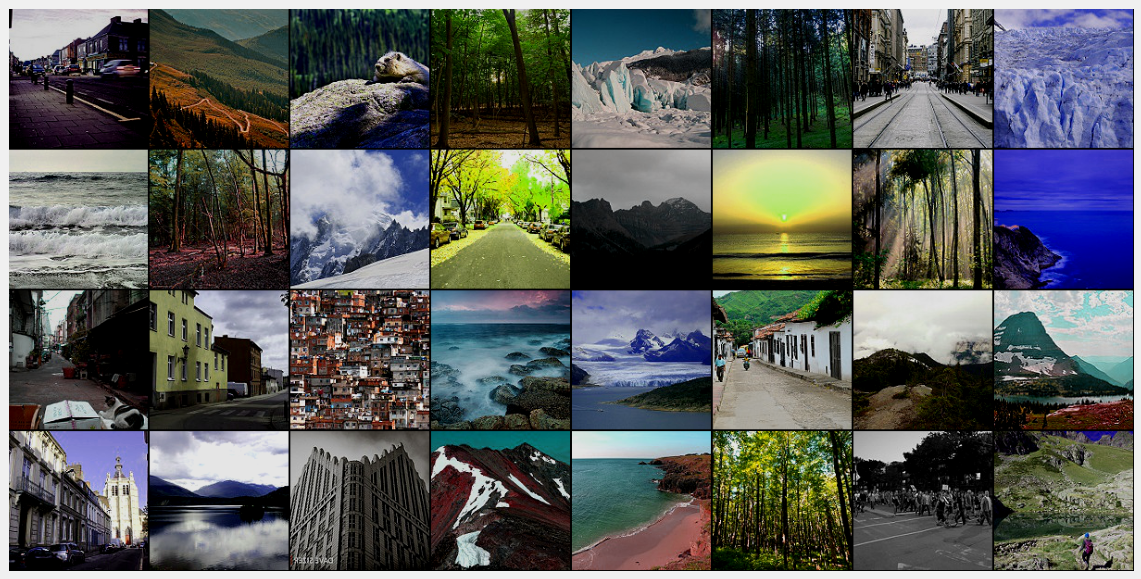

In [147]:
from torchvision.utils import make_grid

def show_augmentation(data_loader):
    for imgs, labels in data_loader:  
        fig, ax = plt.subplots(figsize = (18, 18)) 
        ax.set_xticks([]); ax.set_yticks([]) 
        ax.imshow(make_grid(imgs[:58], nrow = 8).permute(1, 2, 0))     
        break
        
show_augmentation( trainloader )

In [198]:
intel_img_cls_params = { 
                        'model'         : model,
                        'criterion'     : criterion,
                        'optimizer'     : optimizer,
                        'num_epochs'    : hparams['n_epochs'],
                        'dataloaders'   : data_wrangling_obj.dataloaders,
                        'dataset_sizes' : data_wrangling_obj.dataset_sizes,
                        'class_names'   : data_wrangling_obj.class_names,
                        'device'        : device
                        }

                   

intel_image_cls = TrainModel( **intel_img_cls_params )

In [199]:
intel_image_cls.train_model()

Epoch 0/14
---------------
train -  Loss: 0.4445, epoch_acc: 0.8501, cohen_kappa: 1.0000, matthews_corrcoef: 1.0000
micro: acc: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000, fbeta: 1.0000
macro: acc: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000, fbeta: 1.0000

val -  Loss: 0.3032, epoch_acc: 0.8880, cohen_kappa: 0.8478, matthews_corrcoef: 0.8568
micro: acc: 0.8750, precision: 0.8750, recall: 0.8750, f1: 0.8750, fbeta: 0.8750
macro: acc: 0.8968, precision: 0.9111, recall: 0.8968, f1: 0.8870, fbeta: 0.8870

Epoch 1/14
---------------
train -  Loss: 0.2999, epoch_acc: 0.8988, cohen_kappa: 0.9326, matthews_corrcoef: 0.9361
micro: acc: 0.9444, precision: 0.9444, recall: 0.9444, f1: 0.9444, fbeta: 0.9444
macro: acc: 0.9444, precision: 0.9667, recall: 0.9444, f1: 0.9481, fbeta: 0.9481

val -  Loss: 0.3215, epoch_acc: 0.8960, cohen_kappa: 0.8400, matthews_corrcoef: 0.8495
micro: acc: 0.8750, precision: 0.8750, recall: 0.8750, f1: 0.8750, fbeta: 0.8750
macro: acc: 0.7024, prec

The largest value in the array is 1.0000001192092896. To be interpreted as colors correctly values in the array need to be in the [0, 1] range.


train -  Loss: 0.2590, epoch_acc: 0.9109, cohen_kappa: 0.9294, matthews_corrcoef: 0.9331
micro: acc: 0.9444, precision: 0.9444, recall: 0.9444, f1: 0.9444, fbeta: 0.9444
macro: acc: 0.9333, precision: 0.9333, recall: 0.9333, f1: 0.9200, fbeta: 0.9200

val -  Loss: 0.2732, epoch_acc: 0.9083, cohen_kappa: 0.9488, matthews_corrcoef: 0.9509
micro: acc: 0.9583, precision: 0.9583, recall: 0.9583, f1: 0.9583, fbeta: 0.9583
macro: acc: 0.9722, precision: 0.9722, recall: 0.9722, f1: 0.9697, fbeta: 0.9697

Epoch 3/14
---------------


The largest value in the array is 1.0000001192092896. To be interpreted as colors correctly values in the array need to be in the [0, 1] range.


train -  Loss: 0.2377, epoch_acc: 0.9188, cohen_kappa: 0.9305, matthews_corrcoef: 0.9341
micro: acc: 0.9444, precision: 0.9444, recall: 0.9444, f1: 0.9444, fbeta: 0.9444
macro: acc: 0.9167, precision: 0.9583, recall: 0.9167, f1: 0.9206, fbeta: 0.9206

val -  Loss: 0.2648, epoch_acc: 0.9073, cohen_kappa: 0.8418, matthews_corrcoef: 0.8511
micro: acc: 0.8750, precision: 0.8750, recall: 0.8750, f1: 0.8750, fbeta: 0.8750
macro: acc: 0.8611, precision: 0.8472, recall: 0.8611, f1: 0.8040, fbeta: 0.8040

Epoch 4/14
---------------


The largest value in the array is 1.0000001192092896. To be interpreted as colors correctly values in the array need to be in the [0, 1] range.


train -  Loss: 0.2120, epoch_acc: 0.9265, cohen_kappa: 1.0000, matthews_corrcoef: 1.0000
micro: acc: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000, fbeta: 1.0000
macro: acc: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000, fbeta: 1.0000

val -  Loss: 0.2756, epoch_acc: 0.9090, cohen_kappa: 1.0000, matthews_corrcoef: 1.0000
micro: acc: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000, fbeta: 1.0000
macro: acc: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000, fbeta: 1.0000

Epoch 5/14
---------------
train -  Loss: 0.1848, epoch_acc: 0.9344, cohen_kappa: 1.0000, matthews_corrcoef: 1.0000
micro: acc: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000, fbeta: 1.0000
macro: acc: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000, fbeta: 1.0000

val -  Loss: 0.3179, epoch_acc: 0.9010, cohen_kappa: 0.8981, matthews_corrcoef: 0.9020
micro: acc: 0.9167, precision: 0.9167, recall: 0.9167, f1: 0.9167, fbeta: 0.9167
macro: acc: 0.9429, precision: 0.9028, recall: 0.94

The largest value in the array is 1.0000001192092896. To be interpreted as colors correctly values in the array need to be in the [0, 1] range.
The largest value in the array is 1.0000001192092896. To be interpreted as colors correctly values in the array need to be in the [0, 1] range.


train -  Loss: 0.1649, epoch_acc: 0.9414, cohen_kappa: 0.9247, matthews_corrcoef: 0.9289
micro: acc: 0.9444, precision: 0.9444, recall: 0.9444, f1: 0.9444, fbeta: 0.9444
macro: acc: 0.9167, precision: 0.9792, recall: 0.9167, f1: 0.9333, fbeta: 0.9333

val -  Loss: 0.2932, epoch_acc: 0.9080, cohen_kappa: 0.8471, matthews_corrcoef: 0.8489
micro: acc: 0.8750, precision: 0.8750, recall: 0.8750, f1: 0.8750, fbeta: 0.8750
macro: acc: 0.8833, precision: 0.8833, recall: 0.8833, f1: 0.8722, fbeta: 0.8722

Epoch 7/14
---------------
train -  Loss: 0.1573, epoch_acc: 0.9443, cohen_kappa: 1.0000, matthews_corrcoef: 1.0000
micro: acc: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000, fbeta: 1.0000
macro: acc: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000, fbeta: 1.0000

val -  Loss: 0.3155, epoch_acc: 0.9133, cohen_kappa: 0.8494, matthews_corrcoef: 0.8512
micro: acc: 0.8750, precision: 0.8750, recall: 0.8750, f1: 0.8750, fbeta: 0.8750
macro: acc: 0.8750, precision: 0.8917, recall: 0.87

The largest value in the array is 1.0000001192092896. To be interpreted as colors correctly values in the array need to be in the [0, 1] range.
The largest value in the array is 1.0000001192092896. To be interpreted as colors correctly values in the array need to be in the [0, 1] range.


train -  Loss: 0.1432, epoch_acc: 0.9509, cohen_kappa: 0.9326, matthews_corrcoef: 0.9361
micro: acc: 0.9444, precision: 0.9444, recall: 0.9444, f1: 0.9444, fbeta: 0.9444
macro: acc: 0.9583, precision: 0.9583, recall: 0.9583, f1: 0.9524, fbeta: 0.9524

val -  Loss: 0.3390, epoch_acc: 0.9057, cohen_kappa: 0.7833, matthews_corrcoef: 0.7869
micro: acc: 0.8333, precision: 0.8333, recall: 0.8333, f1: 0.8333, fbeta: 0.8333
macro: acc: 0.8815, precision: 0.8472, recall: 0.8815, f1: 0.8559, fbeta: 0.8559

Epoch 9/14
---------------


The largest value in the array is 1.0000001192092896. To be interpreted as colors correctly values in the array need to be in the [0, 1] range.
The largest value in the array is 1.0000001192092896. To be interpreted as colors correctly values in the array need to be in the [0, 1] range.


train -  Loss: 0.1428, epoch_acc: 0.9485, cohen_kappa: 1.0000, matthews_corrcoef: 1.0000
micro: acc: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000, fbeta: 1.0000
macro: acc: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000, fbeta: 1.0000

val -  Loss: 0.3201, epoch_acc: 0.9097, cohen_kappa: 0.6968, matthews_corrcoef: 0.7118
micro: acc: 0.7500, precision: 0.7500, recall: 0.7500, f1: 0.7500, fbeta: 0.7500
macro: acc: 0.7619, precision: 0.7786, recall: 0.7619, f1: 0.7464, fbeta: 0.7464

Epoch 10/14
---------------
train -  Loss: 0.1242, epoch_acc: 0.9550, cohen_kappa: 0.9277, matthews_corrcoef: 0.9315
micro: acc: 0.9444, precision: 0.9444, recall: 0.9444, f1: 0.9444, fbeta: 0.9444
macro: acc: 0.9444, precision: 0.9444, recall: 0.9444, f1: 0.9333, fbeta: 0.9333

val -  Loss: 0.3536, epoch_acc: 0.9123, cohen_kappa: 0.8940, matthews_corrcoef: 0.9001
micro: acc: 0.9167, precision: 0.9167, recall: 0.9167, f1: 0.9167, fbeta: 0.9167
macro: acc: 0.9167, precision: 0.9630, recall: 0.9

The largest value in the array is 1.0000001192092896. To be interpreted as colors correctly values in the array need to be in the [0, 1] range.


train -  Loss: 0.1261, epoch_acc: 0.9546, cohen_kappa: 0.8560, matthews_corrcoef: 0.8560
micro: acc: 0.8889, precision: 0.8889, recall: 0.8889, f1: 0.8889, fbeta: 0.8889
macro: acc: 0.9200, precision: 0.9200, recall: 0.9200, f1: 0.9200, fbeta: 0.9200

val -  Loss: 0.3382, epoch_acc: 0.9140, cohen_kappa: 0.7852, matthews_corrcoef: 0.7888
micro: acc: 0.8333, precision: 0.8333, recall: 0.8333, f1: 0.8333, fbeta: 0.8333
macro: acc: 0.8731, precision: 0.8500, recall: 0.8731, f1: 0.8553, fbeta: 0.8553

Epoch 12/14
---------------
train -  Loss: 0.1120, epoch_acc: 0.9612, cohen_kappa: 0.8605, matthews_corrcoef: 0.8605
micro: acc: 0.8889, precision: 0.8889, recall: 0.8889, f1: 0.8889, fbeta: 0.8889
macro: acc: 0.8833, precision: 0.8833, recall: 0.8833, f1: 0.8833, fbeta: 0.8833

val -  Loss: 0.3168, epoch_acc: 0.9127, cohen_kappa: 1.0000, matthews_corrcoef: 1.0000
micro: acc: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000, fbeta: 1.0000
macro: acc: 1.0000, precision: 1.0000, recall: 1.0

The largest value in the array is 1.0000001192092896. To be interpreted as colors correctly values in the array need to be in the [0, 1] range.


train -  Loss: 0.0939, epoch_acc: 0.9665, cohen_kappa: 0.8543, matthews_corrcoef: 0.8613
micro: acc: 0.8889, precision: 0.8889, recall: 0.8889, f1: 0.8889, fbeta: 0.8889
macro: acc: 0.9267, precision: 0.8933, recall: 0.9267, f1: 0.8974, fbeta: 0.8974

val -  Loss: 0.4192, epoch_acc: 0.9090, cohen_kappa: 0.8462, matthews_corrcoef: 0.8553
micro: acc: 0.8750, precision: 0.8750, recall: 0.8750, f1: 0.8750, fbeta: 0.8750
macro: acc: 0.8889, precision: 0.9246, recall: 0.8889, f1: 0.8904, fbeta: 0.8904

Epoch 14/14
---------------
train -  Loss: 0.1115, epoch_acc: 0.9631, cohen_kappa: 1.0000, matthews_corrcoef: 1.0000
micro: acc: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000, fbeta: 1.0000
macro: acc: 1.0000, precision: 1.0000, recall: 1.0000, f1: 1.0000, fbeta: 1.0000

val -  Loss: 0.4217, epoch_acc: 0.9123, cohen_kappa: 0.8947, matthews_corrcoef: 0.9027
micro: acc: 0.9167, precision: 0.9167, recall: 0.9167, f1: 0.9167, fbeta: 0.9167
macro: acc: 0.9524, precision: 0.9524, recall: 0.9

In [181]:
# torch.cuda.empty_cache()

# type( intel_image_cls.time_elapsed )

In [ ]:
datetime.timedelta(milliseconds=intel_image_cls.time_elapsed  )

datetime.timedelta(seconds=7166, microseconds=139000)

In [ ]:
str( datetime.timedelta(milliseconds=intel_image_cls.time_elapsed ) )

'2:18:49.646000'

In [200]:
intel_image_cls.metrics_df

,epoch,train_loss,val_loss,train_acc_micro,val_acc_micro,train_acc_macro,val_acc_macro,train_cohen_kappa,val_cohen_kappa,train_matthews_corrcoef,val_matthews_corrcoef,train_f1_micro,val_f1_micro,train_f1_macro,val_f1_macro,train_fbeta_micro,val_fbeta_micro,train_fbeta_macro,val_fbeta_macro,train_precision_micro,val_precision_micro,train_precision_macro,val_precision_macro,train_recall_micro,val_recall_micro,train_recall_macro,val_recall_macro
0,1.0,0.444486,0.303234,1.000000,0.875000,1.000000,0.896825,1.000000,0.847780,1.000000,0.856838,1.000000,0.875000,1.000000,0.887037,1.000000,0.875000,1.000000,0.887037,1.000000,0.875000,1.000000,0.911111,1.000000,0.875000,1.000000,0.896825
1,2.0,0.299937,0.321535,0.944444,0.875000,0.944444,0.702381,0.932584,0.840000,0.936117,0.849492,0.944444,0.875000,0.948148,0.708333,0.944444,0.875000,0.948148,0.708333,0.944444,0.875000,0.966667,0.766667,0.944444,0.875000,0.944444,0.702381
2,3.0,0.259034,0.273165,0.944444,0.958333,0.933333,0.972222,0.929412,0.948827,0.933071,0.950855,0.944444,0.958333,0.920000,0.969697,0.944444,0.958333,0.920000,0.969697,0.944444,0.958333,0.933333,0.972222,0.944444,0.958333,0.933333,0.972222
3,4.0,0.237692,0.264759,0.944444,0.875000,0.916667,0.861111,0.930502,0.841758,0.934137,0.851145,0.944444,0.875000,0.920635,0.803968,0.944444,0.875000,0.920635,0.803968,0.944444,0.875000,0.958333,0.847222,0.944444,0.875000,0.916667,0.861111
4,5.0,0.211968,0.275649,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
5,6.0,0.184790,0.317869,1.000000,0.916667,1.000000,0.942857,1.000000,0.898089,1.000000,0.901970,1.000000,0.916667,1.000000,0.911518,1.000000,0.916667,1.000000,0.911518,1.000000,0.916667,1.000000,0.902778,1.000000,0.916667,1.000000,0.942857
6,7.0,0.164935,0.293201,0.944444,0.875000,0.916667,0.883333,0.924686,0.847134,0.928867,0.848936,0.944444,0.875000,0.933333,0.872222,0.944444,0.875000,0.933333,0.872222,0.944444,0.875000,0.979167,0.883333,0.944444,0.875000,0.916667,0.883333
7,8.0,0.157337,0.315541,1.000000,0.875000,1.000000,0.875000,1.000000,0.849372,1.000000,0.851155,1.000000,0.875000,1.000000,0.878968,1.000000,0.875000,1.000000,0.878968,1.000000,0.875000,1.000000,0.891667,1.000000,0.875000,1.000000,0.875000
8,9.0,0.143221,0.338975,0.944444,0.833333,0.958333,0.881482,0.932584,0.783296,0.936090,0.786899,0.944444,0.833333,0.952381,0.855853,0.944444,0.833333,0.952381,0.855853,0.944444,0.833333,0.958333,0.847222,0.944444,0.833333,0.958333,0.881482
9,10.0,0.142833,0.320142,1.000000,0.750000,1.000000,0.761905,1.000000,0.696842,1.000000,0.711830,1.000000,0.750000,1.000000,0.746392,1.000000,0.750000,1.000000,0.746392,1.000000,0.750000,1.000000,0.778571,1.000000,0.750000,1.000000,0.761905


In [201]:
# Pandas DataFrame 
run['metrics/train_val_loss_acc'].upload(File.as_html(intel_image_cls.metrics_df))

In [202]:
# save the trained model to disk
torch.save({
            'epoch': hparams['n_epochs'],
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': criterion, 
            }, './ConvNet.pth')


run['model/model_dict'].upload('./ConvNet.pth')

In [ ]:
# # save the trained model to disk - acc 92% ( VGG16 - trained all fc layers)

# torch.save({
#             'epoch': hparams['n_epochs'],
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': criterion,
#             }, '/content/drive/MyDrive/ColabNotebooks/intel_image/best_model.pth')

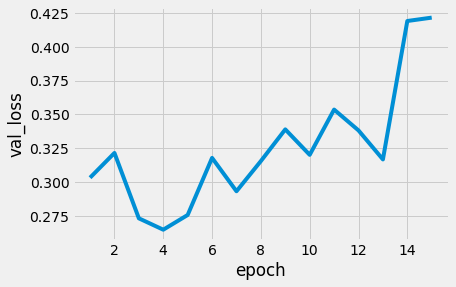

In [203]:
sns.lineplot( data=intel_image_cls.metrics_df, y='val_loss', x='epoch' )

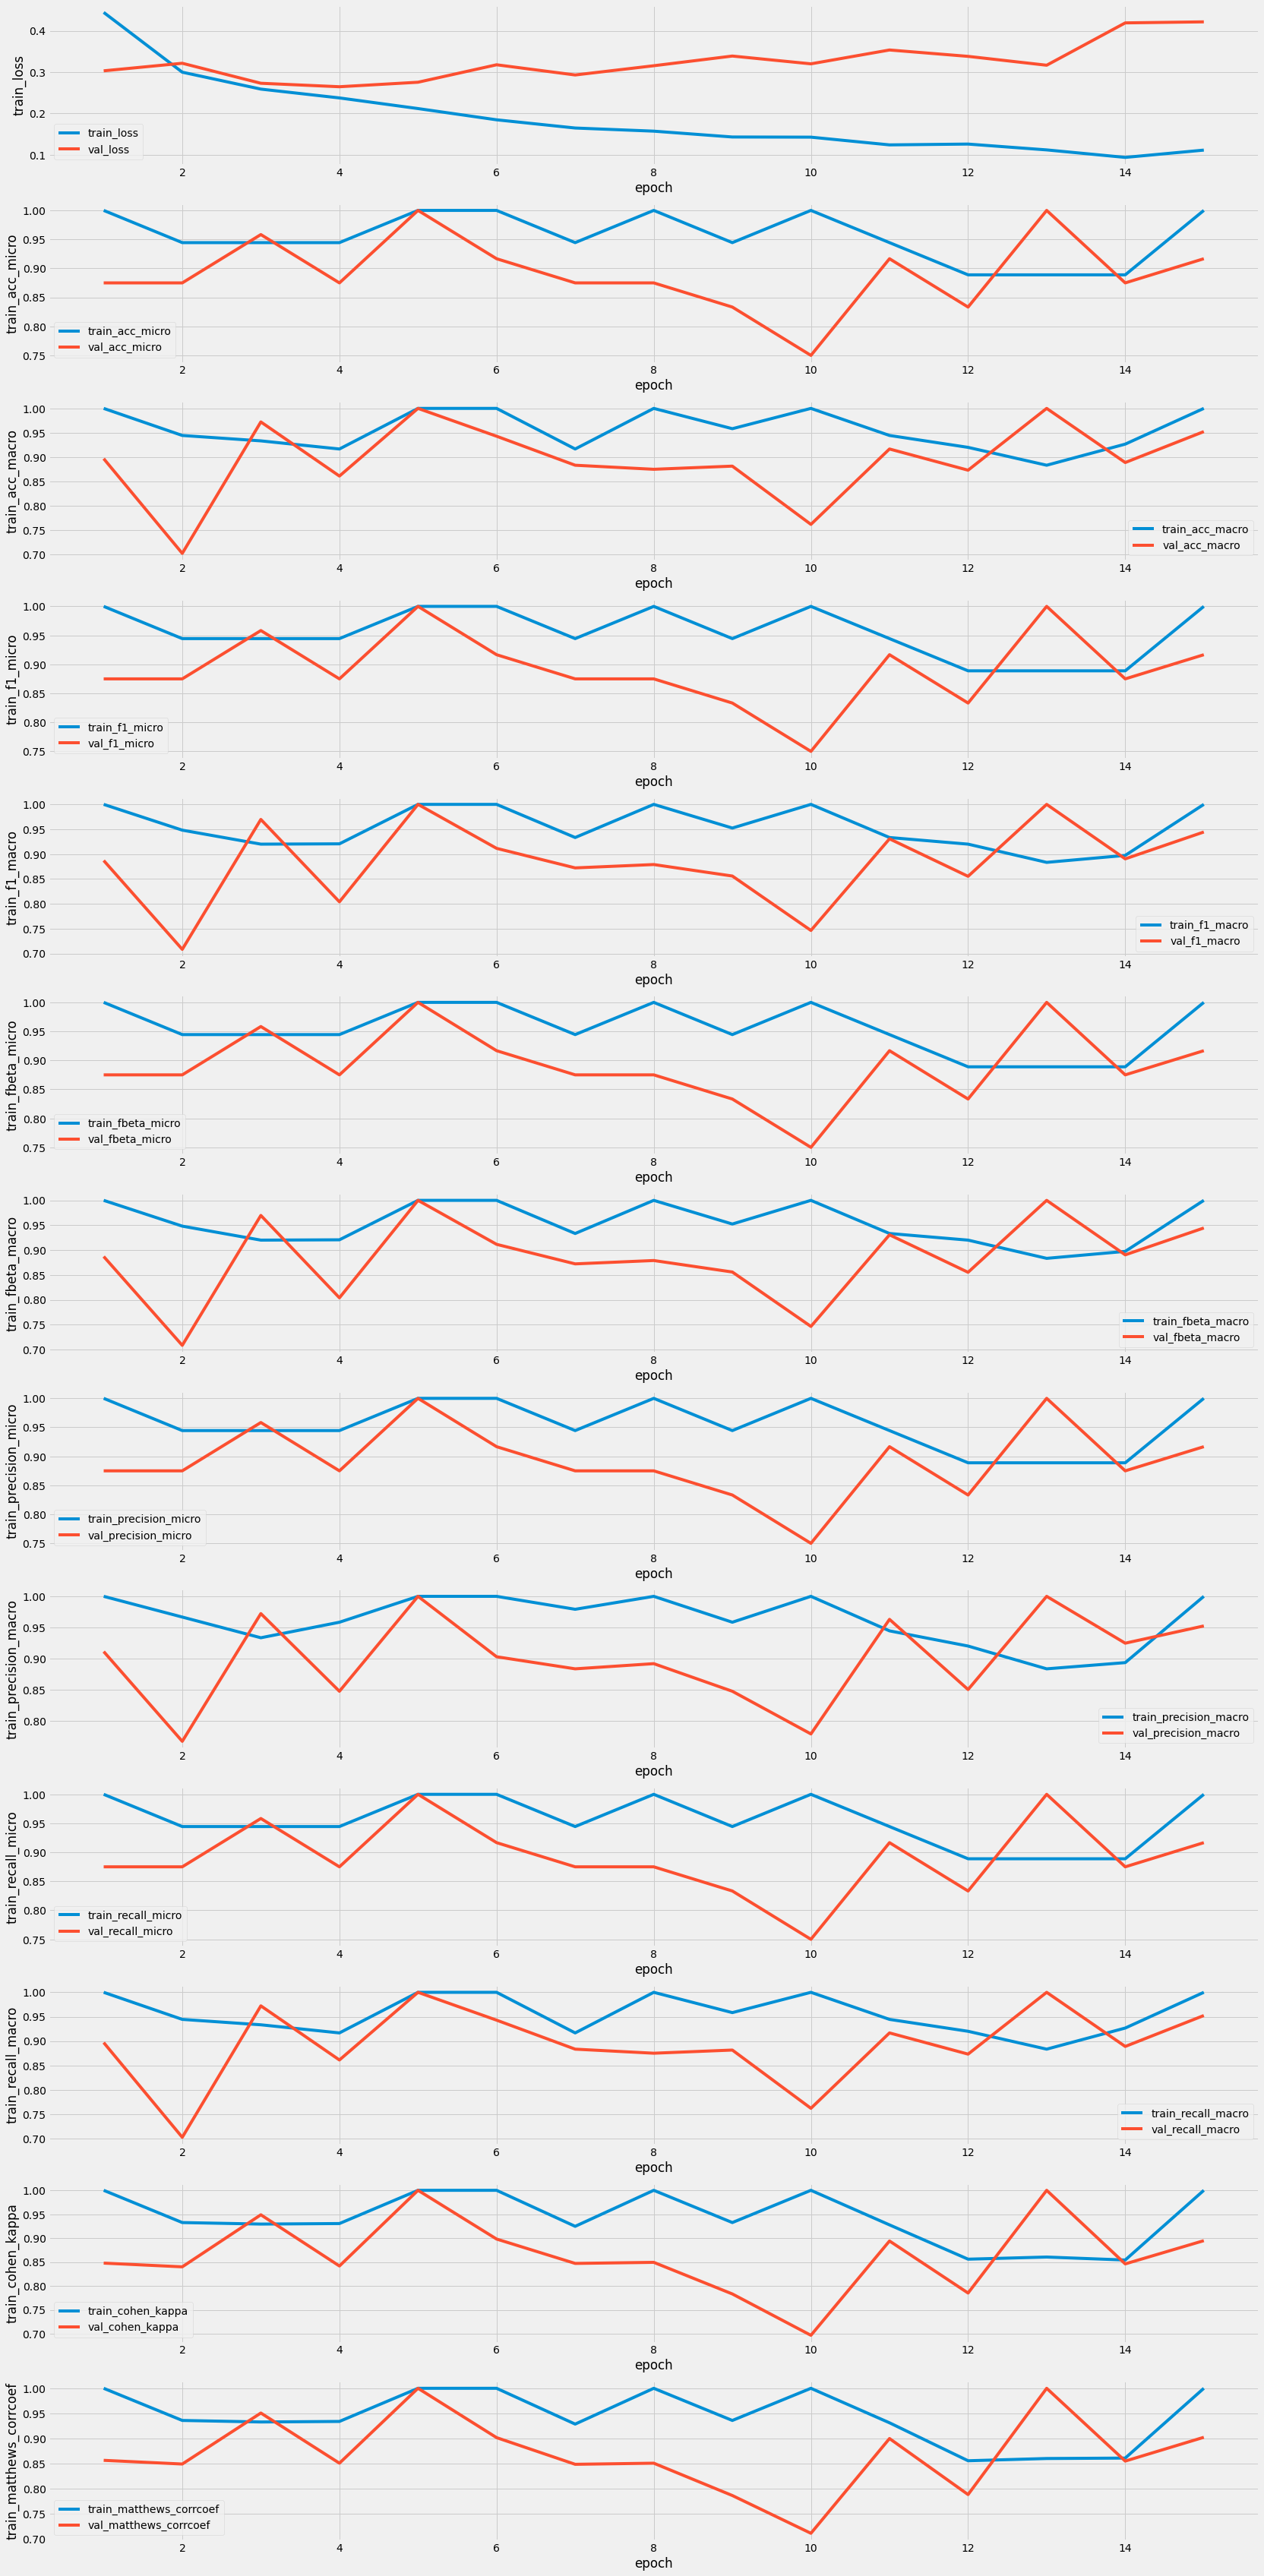

In [204]:
                      # self.train_f1_micro_list,        self.val_f1_micro_list,     
                      # self.train_f1_macro_list,        self.val_f1_macro_list,            

                      # self.train_fbeta_micro_list,     self.val_fbeta_micro_list,    
                      # self.train_fbeta_macro_list,     self.val_fbeta_macro_list,     
                      # self.train_precision_micro_list, self.val_precision_micro_list, 
                      # self.train_precision_macro_list, self.val_precision_macro_list, 
                      # self.train_recall_micro_list,    self.val_recall_micro_list,    
                      # self.train_recall_macro_list,    self.val_recall_macro_list,   
                      # self.train_cohen_kappa_list,     self.val_cohen_kappa_list,    
                      # self.train_mcc_list,             self.val_mcc_list


train_metrics_list = [ 'train_loss', 'train_acc_micro', 'train_acc_macro', 'train_f1_micro', 'train_f1_macro',
                      'train_fbeta_micro', 'train_fbeta_macro', 'train_precision_micro', 'train_precision_macro',
                      'train_recall_micro', 'train_recall_macro', 'train_cohen_kappa', 'train_matthews_corrcoef']

val_metrics_list = [ 'val_loss', 'val_acc_micro', 'val_acc_macro', 'val_f1_micro', 'val_f1_macro',
                      'val_fbeta_micro', 'val_fbeta_macro', 'val_precision_micro', 'val_precision_macro',
                      'val_recall_micro', 'val_recall_macro', 'val_cohen_kappa', 'val_matthews_corrcoef']


fig, ax= plt.subplots(13, 1, figsize=( 23, 47 ), constrained_layout=True )


for row, metrics in enumerate( zip( train_metrics_list, val_metrics_list ) ):
      train_metric, val_metric = metrics
      sns.lineplot( data=intel_image_cls.metrics_df, y=train_metric, x='epoch', label=train_metric, ax=ax[row])
      sns.lineplot( data=intel_image_cls.metrics_df, y=val_metric, x='epoch', label=val_metric, ax=ax[row])
      # run[f'visual/metrics'].log(neptune.types.File.as_image(plt.gcf()))

fig.savefig("metrics.jpg")


plt.show()

In [205]:
run['visual/metrics-fig'].upload(fig)

# Model load

In [ ]:
model = ConvNet()
model.load_state_dict( torch.load('/content/drive/MyDrive/ColabNotebooks/intel_image/model.pth')['model_state_dict']  )

In [ ]:
model = ConvNet()
model.load_state_dict( torch.load('/content/drive/MyDrive/ColabNotebooks/intel_image/best_model.pth', map_location=torch.device('cpu'))['model_state_dict']  )

<All keys matched successfully>

In [ ]:
next(model.parameters()).is_cuda

True

In [ ]:
model.to(device)    

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=8192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=6, bias=True)
)

In [ ]:
next(model.parameters()).is_cuda

False

# confusion matrix

In [206]:
data_wrangling_obj.image_datasets['val']

Dataset ImageFolder
    Number of datapoints: 3000
    Root location: data/val
    StandardTransform
Transform: Compose(
               Resize(size=(150, 150), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.1 0.1 0.1], std=[1 1 1])
           )

In [207]:
valloader = data_wrangling_obj.dataloaders['val']
len( valloader )

94

In [ ]:
data_wrangling_obj.class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
list(data_wrangling_obj.image_datasets['val'].class_to_idx.keys() )

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
data_wrangling_obj.dataset_sizes['val']

In [208]:
test_model_params = { 
                     
                     'data_loader' : valloader,
                     'class_names' : data_wrangling_obj.class_names,
                     'dir_path'    : '/content/data/test/',
                     'data_size'   : data_wrangling_obj.dataset_sizes['val']
                     }



test_model = ModelTesting( **test_model_params,  )

In [ ]:
test_model.dir_path

'/content/data/test/'

In [209]:
%%time
test_model.check_accuracy()

Accuracy of the network on the 3000 val images: 91 %
CPU times: user 19.4 s, sys: 294 ms, total: 19.7 s
Wall time: 19.7 s


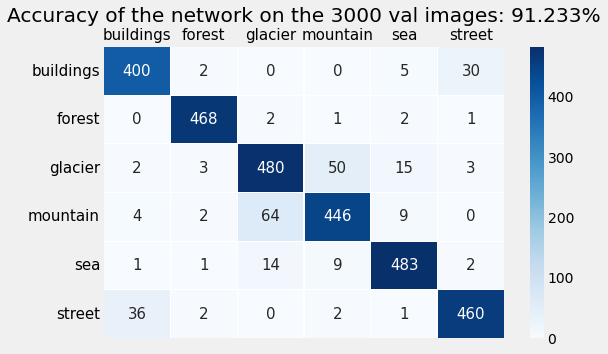

CPU times: user 19.8 s, sys: 520 ms, total: 20.3 s
Wall time: 20.1 s


In [210]:
%%time
test_model.create_confusion_matrix()

In [211]:
test_model.cm_image.savefig("confusion_matrix.jpg", bbox_inches='tight')

run['visual/confusion_matrix'].upload( test_model.cm_image )

run[f"visual/artifacts/confusion_matrix"].track_files('confusion_matrix.jpg')

In [212]:
%%time
test_dir = '/content/data/test/test'

test_model.model_testing( images_dir=test_dir)

CPU times: user 2min 12s, sys: 1.42 s, total: 2min 13s
Wall time: 2min 14s


In [213]:
visualize_imgs_params = { 
                          'number_of_images' : 56,
                          'no_rows'          : 7,
                          'no_cols'          : 8,
                          'set_figsize'      : (21,18),
                          'class_name'       : 'test',
                          'save_to_path'     : './data/prediction_results.jpg',
                          'pred_dict'        : test_model.pred_dict
                        }



test_model.visualize_n_random_images( **visualize_imgs_params )
run['monitoring/test/prediction_results'].log(neptune.types.File.as_image(plt.gcf()))

Output hidden; open in https://colab.research.google.com to view.

# ROC curve and Precision recall

In [214]:
!pip install scikit-plot

from scikitplot.metrics import plot_roc, plot_precision_recall, plot_roc_curve

In [215]:
y_pred = []
y_true = []
y_proba = []

# iterate over test data
with torch.no_grad():
  for inputs, labels in valloader:
    inputs = inputs.to(device)
    output = model(inputs) # Feed Network

    # sm = torch.nn.Softmax()
    # proba = sm(output).detach().cpu().numpy()
    # y_proba.extend(proba)

    _, predicted = torch.max(output.data, 1)
    y_proba.extend( output.cpu().numpy())
    

    output = (torch.max(torch.exp(output), 1))[1].data.cpu().numpy()
    y_pred.extend(output) # Save prediction
                
    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save True val

In [216]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[400,   2,   0,   0,   5,  30],
       [  0, 468,   2,   1,   2,   1],
       [  2,   3, 480,  50,  15,   3],
       [  4,   2,  64, 446,   9,   0],
       [  1,   1,  14,   9, 483,   2],
       [ 36,   2,   0,   2,   1, 460]])

In [219]:
data_wrangling_obj.class_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

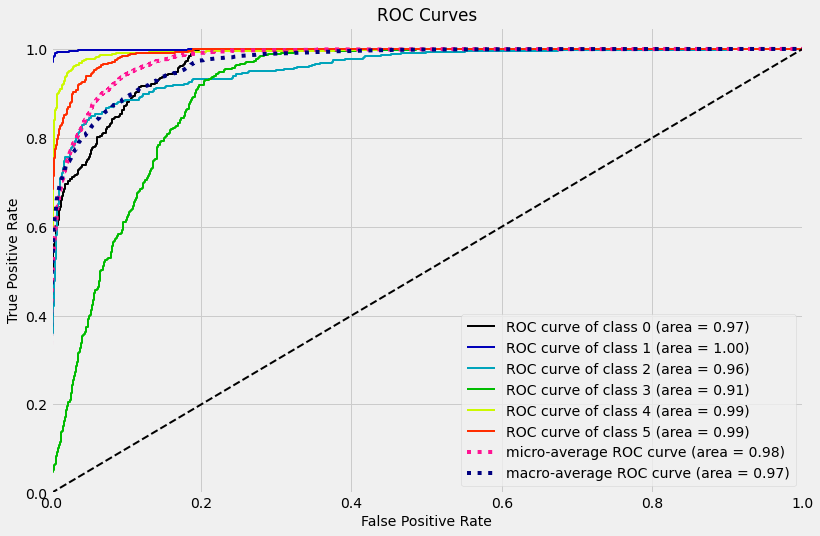

In [217]:
# Log model performance visualizations
fig, ax = plt.subplots( 1, 1, figsize=(12,8), )
plot_roc( y_true, y_proba, ax=ax )

run['visual/ROC'] = neptune.types.File.as_image(fig)
plt.show()

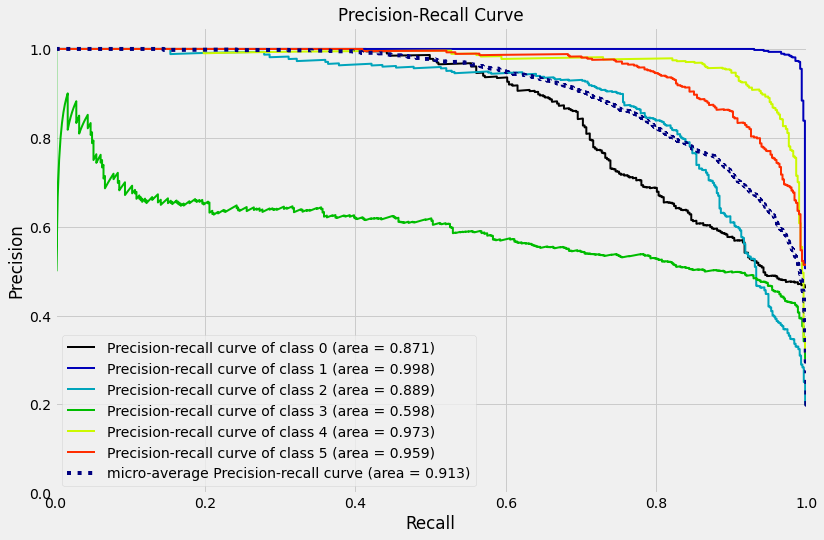

In [218]:
# Log model performance visualizations
fig, ax = plt.subplots( 1, 1, figsize=(12,8), )

plot_precision_recall( y_true, y_proba, ax=ax )

run['visual/precision-recall'] = neptune.types.File.as_image(fig)
plt.show()

# Save model

In [220]:
data = iter(valloader).next()
y = model(data[0].to(device))

In [221]:
model_vis = make_dot(y.mean(), params=dict( model.named_parameters()), )
model_vis.format = "png"
model_vis.render("model_vis")

run["model/visualization"] = neptune.types.File("model_vis.png")

In [222]:

input_names = data_wrangling_obj.class_names
output_names = ['yhat']
torch.onnx.export(model, inputs, 'ConvNet.onnx', input_names=input_names, output_names=output_names, verbose=True,  )

run["model/model_onnx"] = neptune.types.File("ConvNet.onnx")

RuntimeError: ignored

In [ ]:
dummy_input = Variable(torch.randn(3, 3, 150, 150))

torch.onnx.export( model, dummy_input, "model.onnx")
run["model/model_onnx"] = neptune.types.File("ConvNet.onnx")

# Cls report

In [223]:
cls_report = classification_report( test_model.y_true, test_model.y_pred, target_names=test_model.class_names, output_dict=True)

cls_report_df = pd.DataFrame( cls_report ).transpose()

cls_report_df

,precision,recall,f1-score,support
buildings,0.902935,0.915332,0.909091,437.000000
forest,0.979079,0.987342,0.983193,474.000000
glacier,0.857143,0.867993,0.862534,553.000000
mountain,0.877953,0.849524,0.863504,525.000000
sea,0.937864,0.947059,0.942439,510.000000
street,0.927419,0.918164,0.922768,501.000000
accuracy,0.912333,0.912333,0.912333,0.912333
macro avg,0.913732,0.914235,0.913922,3000.000000
weighted avg,0.912180,0.912333,0.912193,3000.000000


In [224]:
run['metrics/classification_report'].upload(File.as_html( cls_report_df ))

In [ ]:
torch.cuda.current_device()

0

In [ ]:
torch.cuda.device_count()

1

In [225]:
torch.cuda.get_device_name(0)

'Tesla K80'

In [226]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 1 operations to synchronize with Neptune. Do not kill this process.


All 1 operations synced, thanks for waiting!


# Other

In [ ]:
x = torch.tensor([
                          [[-0.3000, -0.2926],[-0.2705, -0.2632]],
                          [[-0.1821, -0.1747],[-0.1526, -0.1453]],
                          [[-0.0642, -0.0568],[-0.0347, -0.0274]]
])

print( torch.amax(x, dim=1 ) )
print()
print()
values, indices = torch.max( x, dim=1)
print(f'values= {values}'  )
print()
print(f'indices= {indices}'  )
print()
print(torch.argmax(x, dim=1))
print()
print( x.argmax(dim=1))
print()
print( x.double())
print()
print(x)
print( type( x ))

tensor([[-0.2705, -0.2632],
        [-0.1526, -0.1453],
        [-0.0347, -0.0274]])


values= tensor([[-0.2705, -0.2632],
        [-0.1526, -0.1453],
        [-0.0347, -0.0274]])

indices= tensor([[1, 1],
        [1, 1],
        [1, 1]])

tensor([[1, 1],
        [1, 1],
        [1, 1]])

tensor([[1, 1],
        [1, 1],
        [1, 1]])

tensor([[[-0.3000, -0.2926],
         [-0.2705, -0.2632]],

        [[-0.1821, -0.1747],
         [-0.1526, -0.1453]],

        [[-0.0642, -0.0568],
         [-0.0347, -0.0274]]], dtype=torch.float64)

tensor([[[-0.3000, -0.2926],
         [-0.2705, -0.2632]],

        [[-0.1821, -0.1747],
         [-0.1526, -0.1453]],

        [[-0.0642, -0.0568],
         [-0.0347, -0.0274]]])
<class 'torch.Tensor'>
